In [1]:
import os 
import cv2 as cv
import numpy as np
from tqdm import tqdm

import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"# Using device: {device}")

# Using device: cuda


In [3]:
IMG_SIZE=128

EPOCHS = 50
batch_size = 32
learning_rate = 0.0005

In [4]:
torch.cuda.empty_cache()

In [5]:
def get_dataset(start_id, end_id, img_size):
    patch = []
    mask = []
    for i in range(start_id, end_id):
        img = cv.imread(f'C:/Users/Mateusz/Desktop/Phase2Image/data/grayscale/image_{i}.jpg', cv.IMREAD_GRAYSCALE)
        m_img = cv.imread(f'C:/Users/Mateusz/Desktop/Phase2Image/data/phases/image_{i}.jpg', cv.IMREAD_GRAYSCALE)
        patch.append(img)
        mask.append(m_img)
    patch = np.array(patch)
    mask = np.array(mask)
    X_orig=torch.Tensor([patch[i] for i in range(len(patch))])
    X_phase=torch.Tensor([mask[i] for i in range(len(mask))])

    
    X_orig_flat=X_orig.reshape(-1,1,img_size,img_size)
    X_phase_flat=X_phase.reshape(-1,1,img_size,img_size)
    
    return X_orig_flat, X_phase_flat

In [6]:
X_orig_train, X_phase_train = get_dataset(0, 4500, IMG_SIZE)
X_orig_test, X_phase_test = get_dataset(4500, 5000, IMG_SIZE)

C:\Users\Mateusz\AppData\Local\Temp\ipykernel_8704\620566189.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  X_orig=torch.Tensor([patch[i] for i in range(len(patch))])


In [7]:
X_orig_train.shape

torch.Size([4500, 1, 128, 128])

In [8]:
X_orig_train.shape

torch.Size([4500, 1, 128, 128])

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,32,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),             
                        nn.Conv2d(32,32,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),
                        nn.ReLU(),
        )
                
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out
    
encoder = Encoder().cuda()

In [10]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,1,3,2,1,1),
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        return out

In [11]:
def get_decoder_input(enc_out, batch_size):
    inp = enc_out.view(batch_size, -1)
    return inp.view(batch_size,IMG_SIZE,64,64)

In [12]:
class ImageDataset(Dataset):
    def __init__(self, X_orig, X_phase):
        self.X_orig = X_orig
        self.X_phase = X_phase
    def __getitem__(self, idx):
        return self.X_orig[idx], self.X_phase[idx]
    
    def __len__(self):
        return len(self.X_orig)        

In [13]:
train_dataset = ImageDataset(X_orig_train, X_phase_train)
val_dataset = ImageDataset(X_orig_test, X_phase_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)

In [15]:
def train_model(lr):
    encoder = Encoder().cuda()
    decoder = Decoder().cuda()
    parameters = list(encoder.parameters())+ list(decoder.parameters())
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(parameters, lr=lr)
    train_losses=[]
    valid_losses=[]

    for epoch in tqdm(range(EPOCHS)):
        encoder.train()
        decoder.train()
        
        train_loss = 0
        for i, (train_orig, train_phase) in enumerate(train_loader):
            orig_image = Variable(train_orig).cuda()
            phase_image = Variable(train_phase).cuda()
            
            optimizer.zero_grad()

            encoder_op = encoder(phase_image)
            decoder_inp = get_decoder_input(encoder_op, orig_image.shape[0])
            output = decoder(encoder_op)
            
            loss=loss_func(output,orig_image)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        encoder.eval()
        decoder.eval()
        valid_loss = 0
        with torch.no_grad():
            for i, (test_orig, test_phase) in enumerate(val_loader):
                orig_image = Variable(test_orig).cuda()
                phase_image = Variable(test_phase).cuda()

                encoder_op = encoder(phase_image)
                decoder_inp = get_decoder_input(encoder_op, orig_image.shape[0])
                output = decoder(decoder_inp)
                
                loss=loss_func(output,orig_image)
                valid_loss += loss.item()
        avg_valid_loss = valid_loss / len(val_loader)
        if epoch == 0 or avg_valid_loss < min(valid_losses):
            torch.save([encoder,decoder],f'recover_autoencoder-{lr}.pkl')
        valid_losses.append(avg_valid_loss)
    fig, ax = plt.subplots(2)
    ax[0].plot(train_losses)
    ax[1].plot(valid_losses)
    plt.savefig(f"plot {lr}.jpg")
    plt.clf()

In [16]:
for lr in [1e-2, 1e-3, 1e-4, 1e-5]:
    train_model(lr)

100%|██████████| 50/50 [44:56<00:00, 53.92s/it]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
encoder01, decoder01 = torch.load('recover_autoencoder-0.01.pkl')

encoder001, decoder001 = torch.load('recover_autoencoder-0.001.pkl')

encoder0001, decoder0001 = torch.load('recover_autoencoder-0.0001.pkl')

encoder00001, decoder00001 = torch.load('recover_autoencoder-1e-05.pkl')

In [35]:
loss_func = nn.MSELoss()
valid_loss = 0
recovered_output=[]
for encoder, decoder in [(encoder01, decoder01), (encoder001, decoder001), (encoder0001, decoder0001), (encoder00001, decoder00001)]:
    with torch.no_grad():
        for orig_image, phase_images in tqdm(val_loader):
            print(phase_images.shape)
            orig_image  = Variable(orig_image).cuda()
            hi_variable = Variable(phase_images).cuda()
            encoder_op = encoder(hi_variable)
            decoder_inp = get_decoder_input(encoder_op, phase_images.shape[0])
            output = decoder(decoder_inp)
            
            loss=loss_func(output,orig_image)
            valid_loss += loss.item()
            output=output.cpu()
            output=output.detach().tolist()
            recovered_output.extend(output)
        
        avg_valid_loss = valid_loss / len(val_loader)
        print(avg_valid_loss, valid_loss)


  3%|▎         | 1/32 [00:00<00:06,  4.64it/s]

torch.Size([16, 1, 128, 128])


  9%|▉         | 3/32 [00:00<00:03,  8.92it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 16%|█▌        | 5/32 [00:00<00:02, 10.50it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 28%|██▊       | 9/32 [00:00<00:01, 12.04it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 34%|███▍      | 11/32 [00:00<00:01, 12.50it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 47%|████▋     | 15/32 [00:01<00:01, 12.85it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 53%|█████▎    | 17/32 [00:01<00:01, 11.62it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 66%|██████▌   | 21/32 [00:01<00:00, 12.08it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 72%|███████▏  | 23/32 [00:01<00:00, 12.36it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 84%|████████▍ | 27/32 [00:02<00:00, 11.72it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 91%|█████████ | 29/32 [00:02<00:00, 11.36it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


100%|██████████| 32/32 [00:02<00:00, 11.92it/s]


torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([4, 1, 128, 128])
4095.9273071289062 131069.673828125


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([16, 1, 128, 128])


  6%|▋         | 2/32 [00:00<00:02, 10.96it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 12%|█▎        | 4/32 [00:00<00:02, 11.89it/s]

torch.Size([16, 1, 128, 128])


 19%|█▉        | 6/32 [00:00<00:02, 11.92it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 25%|██▌       | 8/32 [00:00<00:01, 12.13it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 31%|███▏      | 10/32 [00:00<00:01, 11.94it/s]

torch.Size([16, 1, 128, 128])


 38%|███▊      | 12/32 [00:00<00:01, 12.17it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 44%|████▍     | 14/32 [00:01<00:01, 11.56it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 50%|█████     | 16/32 [00:01<00:01, 11.83it/s]

torch.Size([16, 1, 128, 128])


 56%|█████▋    | 18/32 [00:01<00:01, 11.77it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 62%|██████▎   | 20/32 [00:01<00:01, 11.89it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 69%|██████▉   | 22/32 [00:01<00:00, 11.87it/s]

torch.Size([16, 1, 128, 128])


 75%|███████▌  | 24/32 [00:02<00:00, 12.10it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 81%|████████▏ | 26/32 [00:02<00:00, 11.85it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 88%|████████▊ | 28/32 [00:02<00:00, 11.95it/s]

torch.Size([16, 1, 128, 128])


100%|██████████| 32/32 [00:02<00:00, 10.79it/s]


torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([4, 1, 128, 128])
9596.73648071289 307095.5673828125


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([16, 1, 128, 128])


  6%|▋         | 2/32 [00:00<00:02, 12.27it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 12%|█▎        | 4/32 [00:00<00:02, 12.22it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 25%|██▌       | 8/32 [00:00<00:01, 12.06it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 31%|███▏      | 10/32 [00:00<00:01, 11.84it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 44%|████▍     | 14/32 [00:01<00:01, 11.92it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 50%|█████     | 16/32 [00:01<00:01, 12.09it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 62%|██████▎   | 20/32 [00:01<00:00, 12.15it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 69%|██████▉   | 22/32 [00:01<00:00, 11.89it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 81%|████████▏ | 26/32 [00:02<00:00, 12.50it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 88%|████████▊ | 28/32 [00:02<00:00, 12.74it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


100%|██████████| 32/32 [00:02<00:00, 12.46it/s]


torch.Size([16, 1, 128, 128])
torch.Size([4, 1, 128, 128])
15270.081268310547 488642.6005859375


  0%|          | 0/32 [00:00<?, ?it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


  6%|▋         | 2/32 [00:00<00:02, 12.65it/s]

torch.Size([16, 1, 128, 128])


 12%|█▎        | 4/32 [00:00<00:02, 11.94it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 19%|█▉        | 6/32 [00:00<00:02, 11.92it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 25%|██▌       | 8/32 [00:00<00:01, 12.02it/s]

torch.Size([16, 1, 128, 128])


 31%|███▏      | 10/32 [00:00<00:01, 12.20it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 38%|███▊      | 12/32 [00:00<00:01, 11.98it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 44%|████▍     | 14/32 [00:01<00:01, 12.13it/s]

torch.Size([16, 1, 128, 128])


 50%|█████     | 16/32 [00:01<00:01, 11.95it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 56%|█████▋    | 18/32 [00:01<00:01, 11.94it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 69%|██████▉   | 22/32 [00:01<00:00, 11.81it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 75%|███████▌  | 24/32 [00:02<00:00, 11.46it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


 88%|████████▊ | 28/32 [00:02<00:00, 12.07it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])


100%|██████████| 32/32 [00:02<00:00, 13.47it/s]

torch.Size([16, 1, 128, 128])
torch.Size([16, 1, 128, 128])
torch.Size([4, 1, 128, 128])


100%|██████████| 32/32 [00:02<00:00, 12.22it/s]

21000.93295288086 672029.8544921875


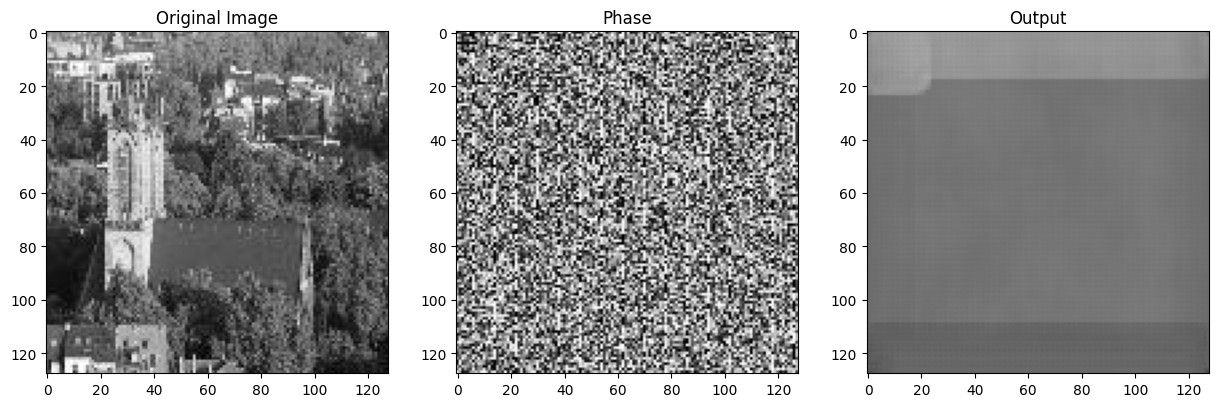

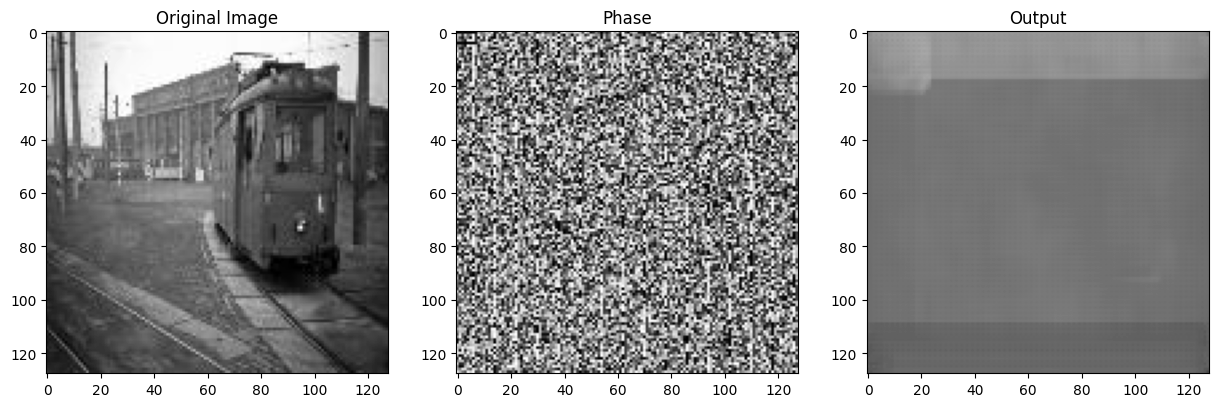

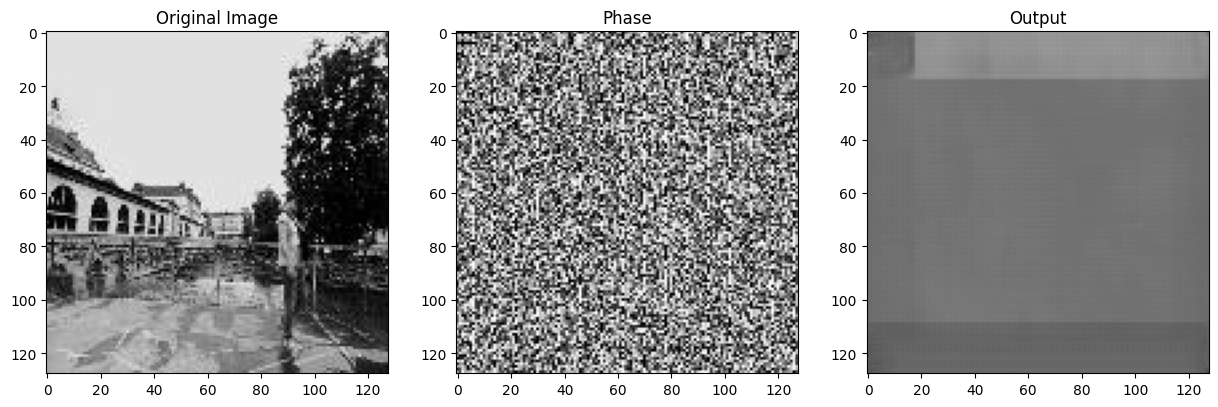

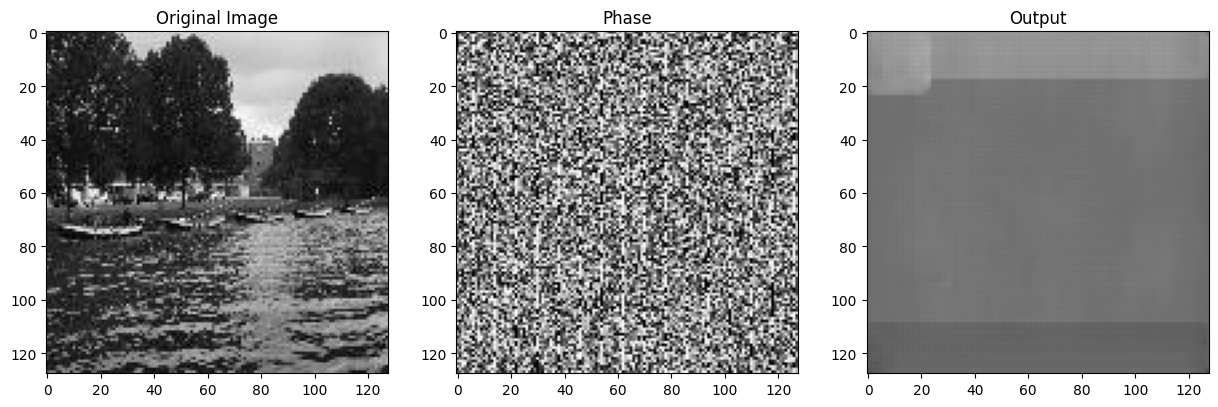

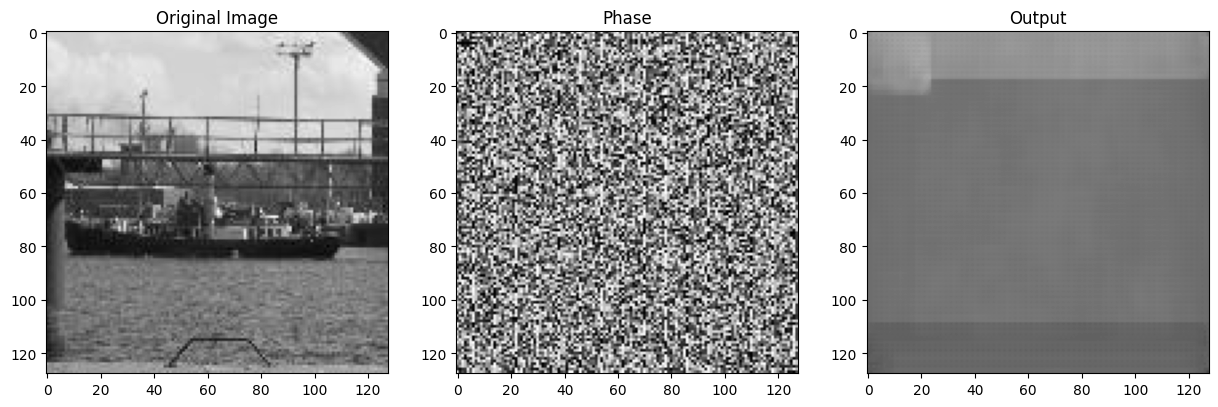

In [40]:
for i in range(0, 500, 100):
    
    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_orig_train[i][0], cmap='gray', vmin=0, vmax=255)
    
    ax = plt.subplot(132)
    plt.title('Phase')
    plt.imshow(X_phase_train[i][0], cmap='gray', vmin=0, vmax=255)
    
    ax = plt.subplot(133)
    plt.title('Output')
    plt.imshow(recovered_output[i][0], cmap='gray', vmin=0, vmax=255)
    plt.show()